# Collaborative Filtering Recommendations - User-Based kNN based on FastRP embeddings

## Introduction

Use Fast Random Projection to create embeddings for Poi and User nodes, then use K-Nearest Neighbors to compute the similarity between User Nodes.

When making recommendation, find the most similar users and recommend other pois that they are alse interested.

[the K-Nearest Neighbors algorithm (kNN)](https://neo4j.com/docs/graph-data-science/current/algorithms/knn/): identify similar nodes and base recommendations on that. 

[FastRP](https://neo4j.com/docs/graph-data-science/current/machine-learning/node-embeddings/fastrp/). leverage topological information about the graph in kNN, first create node embeddings to be the input to the kNN algorithm.

## Prerequisites

Neo4j server with a recent version (2.0+) of GDS installed.

The `graphdatascience` Python library to operate Neo4j GDS.

`Cypher` query to generate recommendations

## Setup

Installing and importing  dependencies, and setting up GDS client connection to the database.

In [44]:
# Install necessary dependencies
%pip install graphdatascience
%pip install matplotlib
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement sklearn.model_selection (from versions: none)
ERROR: No matching distribution found for sklearn.model_selection

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [51]:
import os
import configparser

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from graphdatascience import GraphDataScience

In [52]:
# Using an ini file for credentials, otherwise providing defaults
HOST = 'neo4j://localhost'
DATABASE = 'neo4j'
PASSWORD = 'password'

NEO4J_CONF_FILE = 'neo4j.ini'

if NEO4J_CONF_FILE is not None and os.path.exists(NEO4J_CONF_FILE):
    config = configparser.RawConfigParser()
    config.read(NEO4J_CONF_FILE)
    HOST = config['NEO4J']['HOST']
    DATABASE = config['NEO4J']['DATABASE']
    PASSWORD = config['NEO4J']['PASSWORD']
    print(f'Using custom database properties \nHOST: {HOST}; DATABASE: {DATABASE}; PASSWORD: {PASSWORD}')
else:
    print('Could not find database properties file, using defaults')

# Connecting with the Neo4j database using GDS library
gds = GraphDataScience(HOST,auth=(DATABASE, PASSWORD))

Using custom database properties 
HOST: bolt://44.199.250.187:7687; DATABASE: neo4j; PASSWORD: braids-agent-overvoltage


## Projecting into GDS

Project graph into memory where GDS can operate on and analyze data

In [3]:
# define how to project database into GDS
node_projection = ["User", "Poi"]
relationship_projection = {"REVIEWED": {"orientation": "UNDIRECTED", "properties": "rating"}}

# Before actual projection, estimate how much memory is required
result = gds.graph.project.estimate(node_projection, relationship_projection)

print(f"Required memory for native loading: {result['requiredMemory']}")

Required memory for native loading: [10930 KiB ... 12130 KiB]


In [4]:
# proceed with projection
G, result = gds.graph.project("myGraph", node_projection, relationship_projection)

print(f"The projection took {result['projectMillis']} ms")

# methods on `G` to check if the projection looks correct
print(f"Graph '{G.name()}' node count: {G.node_count()}")
print(f"Graph '{G.name()}' node labels: {G.node_labels()}")

The projection took 2476 ms
Graph 'myGraph' node count: 58725
Graph 'myGraph' node labels: ['User', 'Poi']


## Creating FastRP node embeddings

In order to do collaborative filtering, generate node embeddings that capture topological information from the graph, as input for KNN later.

`embeddingDimension` set to 256 for a graph which has more than 50k nodes. 

Run FastRP’s mutate mode to write the embedding property to the projected graph.

[the syntax section of the FastRP documentation](https://neo4j.com/docs/graph-data-science/current/machine-learning/node-embeddings/fastrp/#algorithms-fastrp-syntax) 

In [5]:
# stimate memory of running algorithms like FastRP
result = gds.fastRP.mutate.estimate(
    G,
    randomSeed=42,
    embeddingDimension=256,
    
    relationshipWeightProperty="rating",
    iterationWeights=[0, 1, 1, 1],
    mutateProperty="embedding"
)

print(f"Required memory for running FastRP: {result['requiredMemory']}")

Required memory for running FastRP: 177 MiB


In [6]:
# run FastRP and mutate our projected graph with the results
result = gds.fastRP.mutate(
    G,
    randomSeed=42,
    embeddingDimension=256,
    relationshipWeightProperty="rating",
    iterationWeights=[0, 1, 1, 1],
    mutateProperty="embedding"
)

print(f"Number of embedding vectors produced: {result['nodePropertiesWritten']}")

Number of embedding vectors produced: 58725


## Similarities with UserkNN

identify similar nodes by using the node embeddings generated with FastRP as `nodeProperties`. 

Use the algorithm’s write mode to write the properties and relationships back to database, analyze them later using Cypher.

[the syntax section of the kNN documentation](https://neo4j.com/docs/graph-data-science/current/algorithms/knn/#algorithms-knn-syntax) 

In [7]:
def topK_tuning():
    
    top_k_list = []

    for k in range(1,30):
        result = gds.knn.write(
        G,
        topK=k,
        nodeLabels=['User'],
        nodeProperties=["embedding"],
        randomSeed=42,
        concurrency=1,
        sampleRate=1.0,
        deltaThreshold=0.0,
        writeRelationshipType="CF_SIMILAR_USER"+str(k),
        writeProperty="score",

        )
        print(f"topK = {k}")
        print(f"Relationships produced: {result['relationshipsWritten']}")
        print(f"Nodes compared: {result['nodesCompared']}")
        print(f"Mean similarity: {result['similarityDistribution']['mean']}")

        top_k_list.append([k, result['similarityDistribution']['mean']])
    
    return top_k_list

In [8]:
top_k_list = topK_tuning() 

# duration of this function will take more than 30 minutes,
# to save re-running time, save the result of top_k_list here
#top_k_list = [[1, 0.9939157612910378], [2, 0.9940597938502739], [3, 0.9944219534603936], [4, 0.9950116373318112], [5, 0.995537629312202], [6, 0.9961105275531317], [7, 0.9967810126999498], [8, 0.9969744809536875], [9, 0.9969924254699816], [10, 0.9973689662324101], [11, 0.9975579028765029], [12, 0.9976186487680783], [13, 0.997599921147859], [14, 0.9975682017576685], [15, 0.997567785239302], [16, 0.9975008765978366], [17, 0.997444304685102], [18, 0.9973874168012433], [19, 0.9973184783989875], [20, 0.9972443387961036], [21, 0.9971741445220691], [22, 0.9971201321036134], [23, 0.9970621580886316], [24, 0.9969813260360726], [25, 0.9968963513631868], [26, 0.9968325522809519], [27, 0.9967747525277024], [28, 0.996695660040167], [29, 0.9966159894369206]]

print(top_k_list)

topK = 1
Relationships produced: 58656
Nodes compared: 58656
Mean similarity: 0.9939157612910378
topK = 2
Relationships produced: 117312
Nodes compared: 58656
Mean similarity: 0.9940597938502739
topK = 3
Relationships produced: 175968
Nodes compared: 58656
Mean similarity: 0.9944219534603936
topK = 4
Relationships produced: 234624
Nodes compared: 58656
Mean similarity: 0.9950116373318112
topK = 5
Relationships produced: 293280
Nodes compared: 58656
Mean similarity: 0.995537629312202
topK = 6
Relationships produced: 351936
Nodes compared: 58656
Mean similarity: 0.9961105275531317
topK = 7
Relationships produced: 410592
Nodes compared: 58656
Mean similarity: 0.9967810126999498
topK = 8
Relationships produced: 469248
Nodes compared: 58656
Mean similarity: 0.9969744809536875
topK = 9
Relationships produced: 527904
Nodes compared: 58656
Mean similarity: 0.9969924254699816
topK = 10
Relationships produced: 586560
Nodes compared: 58656
Mean similarity: 0.9973689662324101
topK = 11
Relationshi

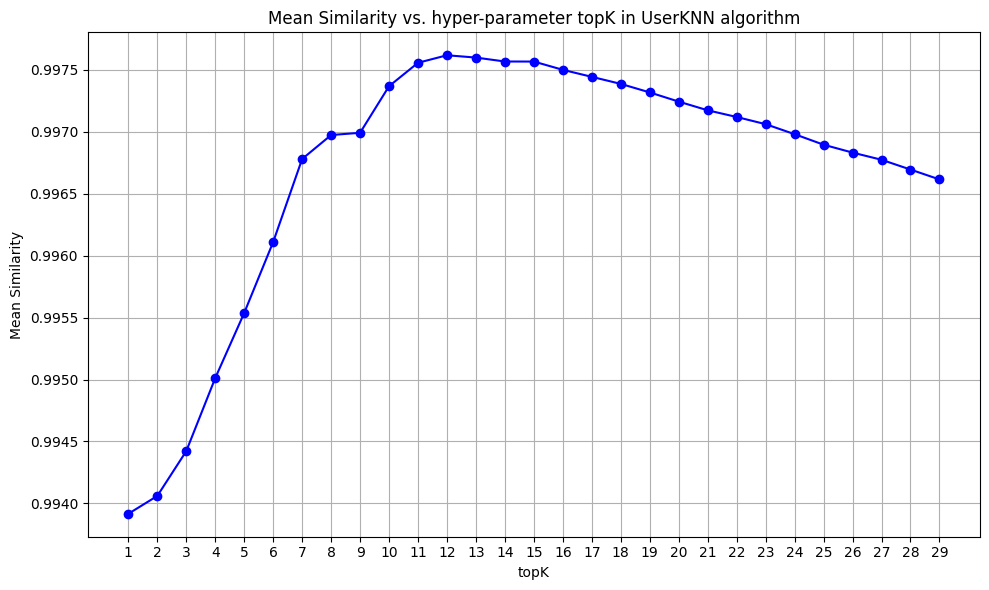

In [9]:
# visualize the Mean Similarity vs. topK trend

# Convert the list to a DataFrame
df_topK = pd.DataFrame(top_k_list, columns=['topK', 'mean_similarity'])

# Plot the line chart
plt.figure(figsize=(10, 6))
plt.plot(df_topK['topK'], df_topK['mean_similarity'], marker='o', color='b', linestyle='-')
plt.title('Mean Similarity vs. hyper-parameter topK in UserKNN algorithm')
plt.xlabel('topK')
plt.ylabel('Mean Similarity')
plt.grid(True)
plt.xticks(df_topK['topK'])
plt.tight_layout()
plt.show()

In [10]:
# get the best topK

# Find the index of the row with the maximum mean_similarity
max_index = df_topK['mean_similarity'].idxmax()

# Retrieve the topK value corresponding to the maximum mean_similarity
topK_best = df_topK.loc[max_index, 'topK']

print("TopK value corresponding to the maximum mean_similarity:", topK_best)


TopK value corresponding to the maximum mean_similarity: 12


In [7]:
# Similarity with User-based KNN

# Run the kNN with optimal topK hyperparameter and write back to db
# duration: 50s

topK_best = 12

result = gds.knn.write(
    G,
    topK=topK_best,
    nodeLabels=['User'],
    nodeProperties=["embedding"],
    randomSeed=42,
    concurrency=1,
    sampleRate=1.0,
    deltaThreshold=0.0,
    writeRelationshipType="CF_SIMILAR_USER",
    writeProperty="score",

)

print(f"Relationships produced: {result['relationshipsWritten']}")
print(f"Nodes compared: {result['nodesCompared']}")
print(f"Mean similarity: {result['similarityDistribution']['mean']}")

Relationships produced: 703872
Nodes compared: 58656
Mean similarity: 0.9976186487680783


As we can see the mean similarity between nodes is rather high. This is due to the fact that there exists quite a number of users who only give rating of 5 to 1 poi, because the connection of these users are sparse and behaviours will be deemed to be similar, leading to many similar FastRP node embeddings.

## Exploring the results

Inspect the results of our kNN call by using Cypher. 

Use the `SIMILARITY` relationship type to filter out the relationships.

In [53]:
# find the maximum similarity between users
gds.run_cypher(
    """
        MATCH (u1:User)-[r:CF_SIMILAR_USER]->(u2:User)
        RETURN u1.name AS user1, u2.name AS user2, r.score AS similarity
        ORDER BY similarity DESCENDING, user1, user2
        LIMIT 30
    """
)

,user1,user2,similarity
0,%E7%87%95%E5%AD%99,138jasonr,1.0
1,%E7%87%95%E5%AD%99,333Ajay,1.0
2,%E7%87%95%E5%AD%99,3heather,1.0
3,%E7%87%95%E5%AD%99,G1740SNchristiant,1.0
4,%E7%87%95%E5%AD%99,IanDio,1.0
5,%E7%87%95%E5%AD%99,Lostinmyhead,1.0
6,%E7%87%95%E5%AD%99,abhooo,1.0
7,%E7%87%95%E5%AD%99,brocdog,1.0
8,%E7%87%95%E5%AD%99,craigp832,1.0
9,%E7%87%95%E5%AD%99,nicholaslojp,1.0


In [54]:
# find the minimum similarity between users
gds.run_cypher(
    """
        MATCH (u1:User)-[r:CF_SIMILAR_USER]->(u2:User)
        RETURN u1.name AS user1, u2.name AS user2, r.score AS similarity
        ORDER BY similarity ASC, user1, user2
        LIMIT 30
    """
)

,user1,user2,similarity
0,bdiddyonfoot,E-seeLyrika,0.550317
1,bdiddyonfoot,GrandTour44301947907,0.550317
2,bdiddyonfoot,Januaryth,0.550317
3,bdiddyonfoot,Niceman2023,0.550317
4,bdiddyonfoot,NsonHoZT,0.550317
5,bdiddyonfoot,Passenger61360628010,0.550317
6,bdiddyonfoot,Thugos12345,0.550317
7,bdiddyonfoot,adelineyeoa,0.550317
8,bdiddyonfoot,hnsolo20,0.550317
9,bdiddyonfoot,scodan92,0.550317


kNN results indicate the similarity among users range from 0.550317 to 1.

## Making recommendations

Make poi recommendations for user from other similar users using a simple Cypher query.

In [38]:
# FUNCTION: make recommendation based on Collaborative Filtering Recommendations - User-Based kNN based on FastRP embeddings
# INPUT: user_id
# OUTPUT: dataframe[user_id, rec_poi_id]

def userKNN_recommendation(user_id):

    result = gds.run_cypher(
        """
            MATCH (u1:User {id: $target_user})-[s:CF_SIMILAR_USER]->(u2:User)-[:REVIEWED]->(p:Poi)
            WITH u1, p, s.score AS user_similarity
            RETURN u1.id as user_id, p.id as rec_poi_id
            ORDER BY user_similarity DESC, p.avgRating DESC
        """, params = {'target_user': user_id}
    )
    result = result.drop_duplicates()
    return result

In [39]:
# target user id
user_id = 3098

userKNN_recommendation(user_id)

,user_id,rec_poi_id
0,3098,2149128
1,3098,310900
2,3098,4400781
3,3098,324542
4,3098,8634325
5,3098,1888876
6,3098,8016698
7,3098,317415
8,3098,644919
9,3098,1888873


# Evaluation

In [55]:
# dataframes of pois
df_pois = gds.run_cypher("""\
    MATCH (poi:Poi)    
    RETURN poi.id
    """)

df_pois

,poi.id
0,2149128
1,310900
2,4400781
3,324542
4,678639
...,...
64,17821111
65,17738872
66,26356283
67,21353012


In [56]:
# dataframes of reviews
# duration: 30s

df_reviews = gds.run_cypher("""\
    MATCH (user:User)-[review:REVIEWED]->(poi:Poi)
    RETURN user.id AS user_id, poi.id AS poi_id
    """)

df_reviews

,user_id,poi_id
0,847,2149128
1,21070,2149128
2,21061,2149128
3,21003,2149128
4,21227,2149128
...,...,...
85029,58650,7275891
85030,58652,7275891
85031,58654,17821111
85032,58656,17821111


In [20]:
# Group by 'user_id' and count occurrences
user_counts = df_reviews.groupby('user_id').size()

# Filter out users with less than 5 occurrences
valid_users = user_counts[user_counts >= 5].index

# Filter the original DataFrame based on valid users
filtered_df_reviews = df_reviews[df_reviews['user_id'].isin(valid_users)].copy()
filtered_df_reviews

,user_id,poi_id
277,20980,2149128
329,20419,2149128
644,20445,2149128
712,20803,2149128
764,20108,2149128
...,...,...
84680,1753,1888873
84685,39201,1888873
84688,6967,1888873
84702,21691,1888873


In [21]:
# Splitting the dataset into 90% training and 10% test sets
df_train, df_test = train_test_split(filtered_df_reviews, test_size=0.1, random_state=100)

df_train

,user_id,poi_id
43559,14882,678639
52599,17393,8634325
78604,25812,315470
81971,8079,13078277
66625,13223,8016698
...,...,...
80529,29227,310896
47967,29380,1837767
14022,7053,2149128
4555,16889,2149128


In [22]:
df_test

,user_id,poi_id
14227,7435,2149128
48823,23137,1837767
59373,41985,1888876
12031,9481,2149128
81597,11220,2138910
...,...,...
44908,4635,678639
82916,38946,2139492
57328,27424,644919
53084,41524,317415


In [41]:
# retrieve recommendation for row in test set
# duration: 500 instances takes 3 minutes

df_all_retrieved = pd.DataFrame()
for index, row in df_test.iterrows():
    user_id = row['user_id']

    recommended_interactions = userKNN_recommendation(user_id)
    
    # Add a new column with the same value for all rows
    recommended_interactions['user_id'] = user_id

    # Concatenate recommended_interactions with test_recommendations
    df_all_retrieved = pd.concat([df_all_retrieved, recommended_interactions], ignore_index=True)

# Drop the duplicates
df_all_retrieved = df_all_retrieved.drop_duplicates()

df_all_retrieved

,user_id,rec_poi_id
0,7435,8016698
1,7435,1837767
2,7435,324542
3,7435,4400781
4,7435,2149128
...,...,...
3946,32830,644919
3947,32830,317415
3948,32830,310900
3949,32830,2149128


In [42]:
# Extracting the true interactions from all the reviews
df_true_interactions = df_reviews.copy()
df_true_interactions

,user_id,poi_id
0,847,2149128
1,21070,2149128
2,21061,2149128
3,21003,2149128
4,21227,2149128
...,...,...
85029,58650,7275891
85030,58652,7275891
85031,58654,17821111
85032,58656,17821111


In [44]:
# Merge the true interactions and test instance on user id
df_all_relevant = pd.merge(df_test, df_true_interactions, on=['user_id'], how='inner')

# Rename the columns poi_id_x to poi_id and poi_id_y to rec_poi_id
df_all_relevant = df_all_relevant.rename(columns={'poi_id_x': 'poi_id', 'poi_id_y': 'rec_poi_id'})

# Drop rows where poi_id is equal to rec_poi_id
df_all_relevant = df_all_relevant[df_all_relevant['poi_id'] != df_all_relevant['rec_poi_id']]
df_all_relevant = df_all_relevant.drop_duplicates()

df_all_relevant

,user_id,poi_id,rec_poi_id
1,7435,2149128,310900
2,7435,2149128,4400781
3,7435,2149128,324542
4,7435,2149128,1837767
5,7435,2149128,317415
...,...,...,...
2739,41524,317415,310896
2740,32830,1888876,324542
2741,32830,1888876,8634325
2743,32830,1888876,8016698


In [57]:
# Get all relevant retrieved instance by merging the true interactions and recommended interactions
df_retrived_relevant = pd.merge(df_all_relevant, df_all_retrieved, on=['user_id', 'rec_poi_id'], how='inner')
df_retrived_relevant

,user_id,poi_id,rec_poi_id
0,7435,2149128,310900
1,7435,1837767,310900
2,7435,324542,310900
3,7435,2149128,4400781
4,7435,1837767,4400781
...,...,...,...
2162,41524,317415,310896
2163,32830,1888876,324542
2164,32830,1888876,8634325
2165,32830,1888876,8016698


In [58]:
# calculate the precision score
relevant_retrieved = df_retrived_relevant.shape[0]
all_retrived = df_all_retrieved.shape[0]

precision = relevant_retrieved / all_retrived

print(f'Precision Score: {precision}')

Precision Score: 0.7123602892833663


In [59]:
# calculate the recall score
relevant_retrieved = df_retrived_relevant.shape[0]
all_relevant = df_all_relevant.shape[0]

recall = relevant_retrieved / all_relevant
print(f'Recall Score: {recall}')

Recall Score: 0.9483588621444201


In [60]:
# calculate the coverage score
num_recommended_pois = df_all_retrieved['rec_poi_id'].nunique()
num_all_pois = df_pois.shape[0]

coverage = num_recommended_pois / num_all_pois
print(f'Coverage Score: {coverage}')

Coverage Score: 0.6231884057971014


## Cleaning up

Delete the GDS in-memory state.

In [50]:
# Remove our projection from the GDS graph catalog
G.drop()

# Remove all the example data from the database
# _ = gds.run_cypher("MATCH (n) DETACH DELETE n")

graphName                                                          myGraph
database                                                             neo4j
databaseLocation                                                     local
memoryUsage                                                               
sizeInBytes                                                             -1
nodeCount                                                            58725
relationshipCount                                                   170068
configuration            {'relationshipProjection': {'REVIEWED': {'aggr...
density                                                           0.000049
creationTime                           2024-03-11T08:01:16.684241827+00:00
modificationTime                       2024-03-11T08:01:30.831690302+00:00
schema                   {'graphProperties': {}, 'nodes': {'User': {'em...
schemaWithOrientation    {'graphProperties': {}, 'nodes': {'User': {'em...
Name: 0, dtype: object